# White Shark Multi-Label CNN

In this version we will be using a local GPU (NVIDIA RTX 2070 8GB card). We will use the vision module under the fast.ai toolbox. This version will be a simple classification algorithm attempting to classify images with sharks and without sharks.

In [1]:
%reload_ext autoreload
%autoreload 2 
%matplotlib inline

We import all the necessary packages. We are going to work with the fastai V1 library which sits on top of Pytorch 1.0.

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate
import numpy as np
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

Set the batch size. We will start with 16 which seems to work with this size GPU.

In [3]:
bs = 16

# Import the data

Set the file path

In [4]:
path = 'D:\\Population Study Videos\\Training Data\\CNN_training_set\\'

Look at the labels csv

In [5]:
df = pd.read_csv(path+'ws_metadata.csv')
df.head()

,Name,Label
0,20191120-GOPR0104-17062.jpg,Caudal Shark
1,20191120-GOPR0104-20011.jpg,Gill Shark
2,20191120-GOPR0104-20028.jpg,Dorsal Gill Pelvic Shark
3,20191120-GOPR0104-20039.jpg,Dorsal Pelvic Shark
4,20191120-GOPR0104-20048.jpg,Pelvic Shark


Create a data bunch

In [6]:
tfms = get_transforms()

In [7]:
np.random.seed(42)
src = (ImageList.from_csv(path, 'ws_metadata.csv')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' '))

In [8]:
data = (src.transform(tfms, size=224)
        .databunch().normalize(imagenet_stats))

Let's look at the data

In [9]:
data.classes

['', 'Caudal', 'Dorsal', 'Gill', 'No_shark', 'Pelvic', 'Shark']

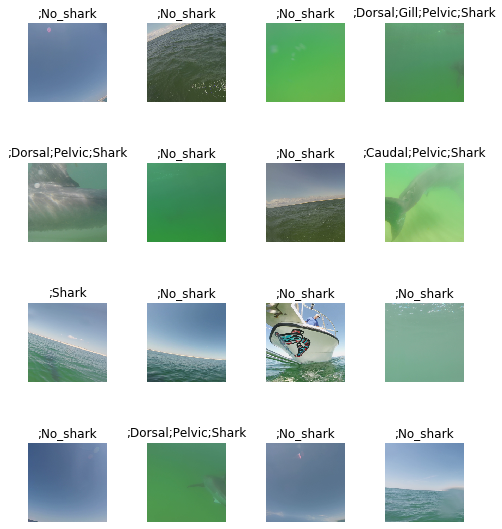

In [10]:
data.show_batch(rows = 4, figsize=(7,8))

Print the class labels, number of classes, number of images in the training set and the number of images in the validation set

In [11]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['', 'Caudal', 'Dorsal', 'Gill', 'No_shark', 'Pelvic', 'Shark'],
 7,
 35781,
 8945)

# Train the model - RESNET 50

This model is the resnet50 convolutional neural network, which is a robust, medium sized model. This model is pre-trained on the imagenet dataset. This first iteration of fitting will fine-tune the outputs from the imagenet classes to our classes.

Set the model architecture

In [12]:
arch = models.resnet50

Our base architecture is resnet50 again, but the metrics are a little bit differeent: we use accuracy_thresh instead of accuracy. It was determined the predicition for a given class by picking the final activation that was the biggest, but here, each activation can be 0. or 1. accuracy_thresh selects the ones that are above a certain threshold (0.5 by default) and compares them to the ground truth.

As for Fbeta, it's the metric that was used by Kaggle on this competition.


In [13]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, arch, metrics=[acc_02, f_score])

We use the LR Finder to pick a good learning rate.

In [14]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


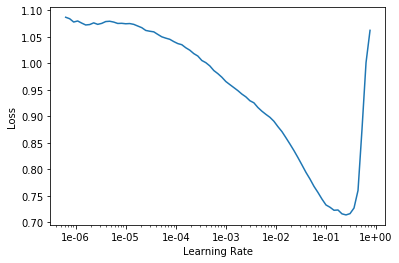

In [15]:
learn.recorder.plot()

Fit the model

In [16]:
lr = 0.01

In [17]:
learn.fit_one_cycle(10, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.148654,0.109336,0.938225,0.953584,21:02
1,0.122149,0.090709,0.951992,0.962320,23:31
2,0.108413,0.079223,0.960089,0.967250,23:10
3,0.100741,0.075291,0.961910,0.969025,22:46
4,0.096242,0.068869,0.963092,0.971964,20:58
5,0.086189,0.065955,0.960760,0.973204,21:09
6,0.080725,0.064140,0.962278,0.973886,21:11
7,0.077679,0.058362,0.967708,0.976869,22:55
8,0.076065,0.057377,0.967771,0.977197,23:28
9,0.073948,0.057289,0.967308,0.977491,23:27


In [18]:
learn.save('ws_multi_label_stage-1')

Let's unfreeze the last couple layers and fine-tune the convolutional layers to improve the customization.

In [19]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


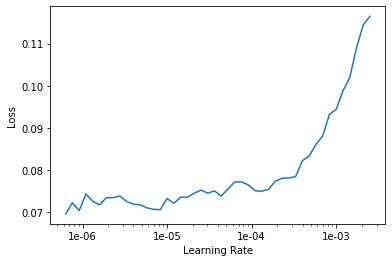

In [20]:
learn.lr_find()
learn.recorder.plot()

In [21]:
learn.fit_one_cycle(12, slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.070832,0.057382,0.967627,0.977023,16:22
1,0.074206,0.060677,0.961846,0.975417,15:56
2,0.075534,0.060537,0.962245,0.974863,15:56
3,0.073418,0.056346,0.965104,0.977250,15:59
4,0.067417,0.054446,0.970391,0.978020,15:57
5,0.067225,0.054019,0.970055,0.978581,15:59
6,0.057763,0.049881,0.972722,0.980412,15:56
7,0.053694,0.048036,0.972562,0.981171,15:56
8,0.049084,0.048510,0.972147,0.980838,15:56
9,0.044459,0.046943,0.974495,0.981655,15:55


In [23]:
learn.save('stage-2')

In [26]:
learn.export('WS_Multi_RESNET_50.pkl')